In [1]:
import numpy as np
from scipy.fft import dct
from scipy import sparse
from sklearn.random_projection import johnson_lindenstrauss_min_dim, GaussianRandomProjection
import matplotlib.pyplot as plt
import scipy.io as sio
import time

In a nutshell, `fjlt_sfd` works best and it needs only numpy. Just use the code below as needed.

# Test different embedding methods

In [2]:
def calc_dist(x1, x2):
    """
    l2-distance between points x1 and x2.
    """
    return np.linalg.norm(x1 - x2)

def eval_dist(A, A_embedded):
    """
    Calculate l2 distances between points (column vectors) for the original matrix A
    and the embedded matrix A_embedded. Calculate only for the pairs of points of adjacent 
    indices (it's simple this way).
    """
    N = A.shape[1]
    dist = np.zeros(N - 1)
    dist_embedded = np.zeros(N - 1)
    for i in range(N - 1):
        dist[i] = calc_dist(A[:, i], A[:, i + 1])
        dist_embedded[i] = calc_dist(A_embedded[:, i], A_embedded[:, i + 1])
    distortion = (dist - dist_embedded) / dist
    return distortion

def test_embedding_method(A, k, method):
    """
    Apply an embedding method. Check time and the distortion in l2 distances between points.
    """
    start_time = time.time()
    A_embedded = method(A, k)
    print('Time: {} s'.format(time.time() - start_time))
    distortion = eval_dist(A, A_embedded)
    dist_abs = np.abs(distortion)
    print('Mean absolute distortion: {}, std = {}'.format(dist_abs.mean(), dist_abs.std()))
    print('--------------------------')
    return distortion

In [3]:
def gaussian_random_projection(A, k):
    """
    Gaussian random projection from sklearn.
    """
    transformer = GaussianRandomProjection(n_components=k)
    A_embedded = transformer.fit_transform(A.T).T
    return A_embedded

# def fjlt_mathen(A, k):
#     """
#     FJLT implementation taken from https://github.com/michaelmathen/FJLT.
#     Require the Fast Hadamard Transform package from https://github.com/nbarbey/fht.
    
#     Note:
#         I don't understand what q is, but apparently higher q = less distortion and more time.
#     """
#     import fjlt
#     return fjlt.fjlt(A, k, q=0.0001)

def fjlt_sfd(A, k):
    """
    A variant of FJLT. See the following resources:
        - The review section (page 3) of https://arxiv.org/abs/1909.04801
        - Page 1 of https://www.sketchingbigdata.org/fall17/lec/lec9.pdf
    
    Note:
        I name it sfd because the matrices are called S(ample), F(ourier transform), D(iagonal).
    """
    d = A.shape[0]
    sign_vector = np.random.randint(0, 2, size=(d, 1)) * 2 - 1
    idx = np.zeros(k, dtype=int)
    idx[1:] = np.random.choice(d - 1, k - 1, replace=False) + 1
    DA = sign_vector * A
    FDA = np.fft.fft(DA, axis=0, norm='ortho')
    A_embedded = np.sqrt(d / k) * FDA[idx]
    return A_embedded

def fjlt_dct(A, k):
    """
    Like fjlt_sfd, but use DCT instead of FFT.
    """
    d = A.shape[0]
    sign_vector = np.random.randint(0, 2, size=(d, 1)) * 2 - 1
    idx = np.zeros(k, dtype=int)
    idx[1:] = np.random.choice(d - 1, k - 1, replace=False) + 1
    DA = sign_vector * A
    FDA = dct(DA, axis=0, norm='ortho')
    A_embedded = np.sqrt(d / k) * FDA[idx]
    return A_embedded

def sjlt_dense_rep(A, k):
    """
    Yin et al. 2020 ESE: Extremely Sparse JL Transform.
    
    Note:
        The description in the paper embed each row of the data matrix.
        For comparison with other methods, I will embed columns instead.
        I use dense matrix representation here for prototyping.
    """
    d = A.shape[0]
    h = np.random.choice(d, size=k)
    sigma = np.random.choice([-1, 1], size=d)
    R = np.zeros((d, k))
    for j in range(k):
        R[h[j], j] = sigma[h[j]]
    A_sjlt = (np.sqrt(d / k) * A.T @ R).T
    return A_sjlt

In [4]:
# Parameters
d = 10000  # Dimension of each point
N = 100    # Number of points
k = johnson_lindenstrauss_min_dim(d, eps=0.15)  # Dimension to embed to
print('Embed {} dim -> {} dim'.format(d, k))

# Generate data matrix A. Each data point is a column vector.
A = np.random.rand(d, N)

Embed 10000 dim -> 3638 dim


In [5]:
err_gauss = test_embedding_method(A, k, gaussian_random_projection)
# err_mathen = test_embedding_method(A, k, fjlt_mathen)
err_sfd = test_embedding_method(A, k, fjlt_sfd)
err_dct = test_embedding_method(A, k, fjlt_dct)
err_sjl = test_embedding_method(A, k, sjlt_dense_rep)

Time: 0.9364757537841797 s
Mean absolute distortion: 0.008997080666594917, std = 0.007338566603272394
--------------------------
Time: 0.027803659439086914 s
Mean absolute distortion: 0.0053283599113319625, std = 0.004260907010715281
--------------------------
Time: 0.021997690200805664 s
Mean absolute distortion: 0.007366922466031124, std = 0.0053735208106712486
--------------------------
Time: 0.17461204528808594 s
Mean absolute distortion: 0.007346970188065582, std = 0.005402003561918983
--------------------------


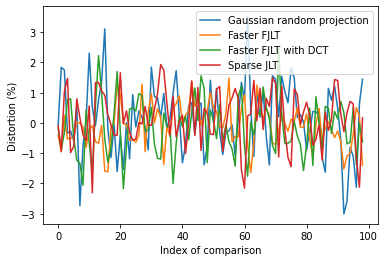

In [6]:
plt.plot(err_gauss * 100, label='Gaussian random projection')
# plt.plot(err_mathen * 100, label='Original FJLT (from Mathen)')  # I didn't tune q carefully
plt.plot(err_sfd * 100, label='Faster FJLT')
plt.plot(err_dct * 100, label='Faster FJLT with DCT')
plt.plot(err_sjl * 100, label='Sparse JLT')
plt.xlabel('Index of comparison')
plt.ylabel('Distortion (%)')
plt.legend()
plt.show()

# Find compression-error tradeoff of different methods

In [7]:
def run_many_k(A, k_list, method):
    time_hist = np.zeros(len(k_list))
    err_hist = np.zeros(len(k_list))
    for i, k in enumerate(k_list):
        start_time = time.time()
        A_embedded = method(A, k)
        time_hist[i] = time.time() - start_time
        distortion = eval_dist(A, A_embedded)
        err_hist[i] = np.abs(distortion).mean()
    return time_hist, err_hist

In [8]:
k_list = np.arange(1000, 10001, 1000)  # [1000, 2000, ..., 10000]

In [9]:
# time_mathen, errhist_mathen = run_many_k(A, k_list, fjlt_mathen)
time_sfd, errhist_sfd = run_many_k(A, k_list, fjlt_sfd)
time_sjl, errhist_sjl = run_many_k(A, k_list, sjlt_dense_rep)

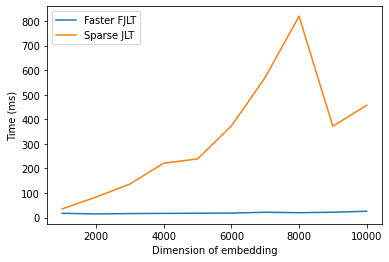

In [10]:
# plt.plot(k_list, time_mathen * 1e3, label='Mathen FJLT')
plt.plot(k_list, time_sfd * 1e3, label='Faster FJLT')
plt.plot(k_list, time_sjl * 1e3, label='Sparse JLT')
plt.xlabel('Dimension of embedding')
plt.ylabel('Time (ms)')
plt.legend()
plt.show()

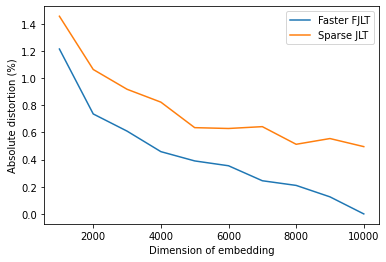

In [11]:
# plt.plot(k_list, errhist_mathen * 100, label='Mathen FJLT')
plt.plot(k_list, errhist_sfd * 100, label='Faster FJLT')
plt.plot(k_list, errhist_sjl * 100, label='Sparse JLT')
plt.xlabel('Dimension of embedding')
plt.ylabel('Absolute distortion (%)')
plt.legend()
plt.show()

# Sparse JL Transform

In [51]:
def eval_dist_sparse(A, A_embedded, num_comparison=100):
    """
    Calculate l2 distances between points (row vectors) for the original sparse matrix A
    and the sparse embedded matrix A_embedded. Calculate only for the pairs of points of adjacent 
    indices (it's simple this way).
    """
    assert A.shape[0] >= num_comparison
    dist = np.zeros(num_comparison - 1)
    dist_embedded = np.zeros(num_comparison - 1)
    for i in range(num_comparison - 1):
        dist[i] = (A[i] - A[i + 1]).power(2).sum()
        dist_embedded[i] = (A_embedded[i] - A_embedded[i + 1]).power(2).sum()
    distortion = (dist - dist_embedded) / dist
    return distortion, dist, dist_embedded

In [13]:
def sjlt_sparse_rep(A, k):
    """
    Yin et al. 2020 ESE: Extremely Sparse JL Transform. Implemented for scipy.sparse representation.
    """
    d = A.shape[1]
    h = np.random.choice(d, size=k)
    sigma = np.random.choice([-1, 1], size=d)
    R = sparse.lil_matrix((d, k))
    for j in range(k):
        R[h[j], j] = sigma[h[j]]
    R = R.tocsc()
    A_sjlt = (A.dot(R)).multiply(np.sqrt(d / k))
    return A_sjlt

In [14]:
# Parameters
d = 10000  # Dimension of each point
N = 100    # Number of points
k = johnson_lindenstrauss_min_dim(d, eps=0.15)  # Dimension to embed to
print('Embed {} dim -> {} dim'.format(d, k))

# Generate data matrix A. Each data point is a row vector.
A = sparse.csc_matrix(np.random.rand(N, d))

Embed 10000 dim -> 3638 dim


In [15]:
A_sjlt = sjlt_sparse_rep(A, k)

In [16]:
distortion, dist, dist_embedded = eval_dist_sparse(A, A_sjlt)

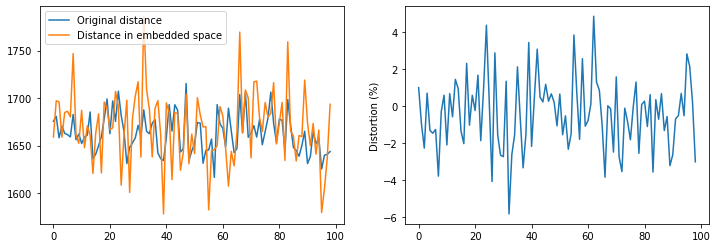

In [17]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 4))
ax[0].plot(dist, label='Original distance')
ax[0].plot(dist_embedded, label='Distance in embedded space')
ax[0].legend()
ax[1].plot(distortion * 100)
ax[1].set_ylabel('Distortion (%)')
fig.show()

# Test Sparse JLT with test matrices

In [62]:
# File names
A_dir = 'matrices/Trefethen_32768.mat'
Mstar_dir = 'matrices/Trefethen_SSAI_32768.mat'

# Load matrices
A = sio.loadmat(A_dir, squeeze_me=True)['tref2']
Mstar = sio.loadmat(Mstar_dir, squeeze_me=True)['Mst']

# Parameters
d = A.shape[0]
k = johnson_lindenstrauss_min_dim(d, eps=0.1)
print('Embed {} dim -> {} dim'.format(d, k))

# Calculate S
Id = sparse.eye(d).tocsc()
MA = Mstar.dot(A)
S = Id.multiply(2) - MA - MA.transpose()

Embed 32768 dim -> 8911 dim


In [63]:
# Project S
SOmega = sjlt_sparse_rep(S, k)

In [64]:
distortion, dist, dist_embedded = eval_dist_sparse(S, SOmega, num_comparison=100)

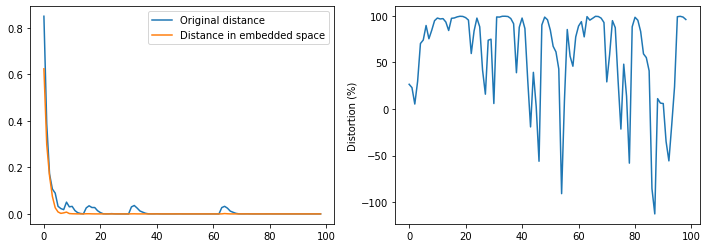

In [65]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 4))
ax[0].plot(dist, label='Original distance')
ax[0].plot(dist_embedded, label='Distance in embedded space')
ax[0].legend()
ax[1].plot(distortion * 100)
ax[1].set_ylabel('Distortion (%)')
fig.show()